# Link Volumes Visualization

Visualize link volumes using Geopandas.

## Setup

In [11]:
import jpype as jp
import jpype.imports as jimport
import os
from shutil import rmtree
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import mplleaflet
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
jimport.registerDomain('org')

classpath = os.pathsep.join(('matsim-0.10.1/matsim-0.10.1.jar', 'matsim-0.10.1/lib/*'))
jp.startJVM(jp.getDefaultJVMPath(), '-Djava.class.path=%s -Xmx1g' % classpath)

In [3]:
from org.matsim.core.scenario import ScenarioUtils
from org.matsim.core.config import ConfigUtils
from org.matsim.api.core.v01 import Id
from org.matsim.core.controler import Controler
from org.matsim.core.controler.OutputDirectoryHierarchy import OverwriteFileSetting
from org.matsim.api.core.v01.events.handler import LinkEnterEventHandler, LinkLeaveEventHandler, VehicleEntersTrafficEventHandler, VehicleLeavesTrafficEventHandler

##  Setup Scenario

Setup a simple scenario.

In [4]:
config = ConfigUtils.loadConfig('matsim-0.10.1/examples/siouxfalls-2014/config_default.xml')
config.controler().setLastIteration(0)
config.controler().setOverwriteFileSetting(OverwriteFileSetting.deleteDirectoryIfExists)

scenario = ScenarioUtils.loadScenario(config)

## Network

We transform the MATSim network to a GeoPandas data frame and
display it.


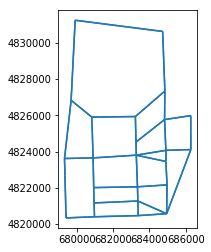

In [5]:
def to_lines(network):
    for link in network.getLinks().values():
        start_coord = link.getFromNode().getCoord()
        end_coord = link.getToNode().getCoord()
        # TODO add Id
        yield {
            'id': link.getId().toString(),
            'length': link.getLength(),
            'geometry': LineString([(start_coord.getX(), start_coord.getY()), (end_coord.getX(), end_coord.getY())])
        }

network_frame = gpd.GeoDataFrame.from_records(list(to_lines(scenario.getNetwork())))
network_frame.crs = {'init': 'epsg:26914'}

ax = network_frame.plot()

`mplleaflet` allows to have a zoomable map with a background, but does not render in the static version (eg. on Github):

In [6]:
mplleaflet.display(fig=ax.figure, crs=network_frame.crs, tiles='esri_natgeo')

## Event Handler

We create an handler that collects time-binned link volumes in
a data frame.

In [7]:
class VolumeHandler:
    increments = {
        'entered link': 1,
        'left link': -1,
        'vehicle enters traffic': 1,
        'vehicle leaves traffic': -1
    }
    ####################################################################
    # Methods for the python side
    ####################################################################
    def __init__(self):
        self.volumes = []

    def get_events_table(self):
        return pd.DataFrame.from_records(self.volumes)

    ####################################################################
    # Methods for the java side
    ####################################################################
        
    def handleEvent(self, event):
        # This method will receive all events, as polymorphic dispatch is
        # not possible in Python. Here this is actually nice, but could be
        # annoying in other cases.
        self.volumes.append(
            {
                'time': event.getTime(),
                # Not using toString stores the IDs as java objects. That works fine
                # for lots of purpose, but not all (for instance groupBy)
                'link': event.getLinkId().toString(),
                'type': event.getEventType(),
                'increment': self.increments[event.getEventType()]
            })
        
    def reset(self, iteration):
        self.volumes = []
    
    # JProxy does not provide default implementation for those methods:
    # provide one, to avoid crashes.
    # In true python way, the JProxy checks if a method exists only if actually
    # invoked.
    def hashCode(self):
        return 42
    
    def toString(self):
        return "%s" % self

handler = VolumeHandler()
handlerProxy = jp.JProxy((LinkLeaveEventHandler, LinkEnterEventHandler, VehicleEntersTrafficEventHandler, VehicleLeavesTrafficEventHandler), inst=handler)

## Run Simulation

In [8]:
controler = Controler(scenario)

controler.getEvents().addHandler(handlerProxy)

controler.run()
rmtree('output/')
table = handler.get_events_table()

## Analysis

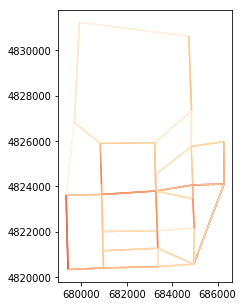

In [12]:
def get_volumes(table, start_h, end_h):
    return table[(table.increment > 0) & (table.time >= start_h * 3600) & (table.time < end_h * 3600)]\
        .assign(volume=0)\
        .groupby('link').volume.count().reset_index()

def plot_volumes(network, events, start_h, end_h, ax=None):
    volumes = get_volumes(events, start_h, end_h)
    return network.merge(volumes, how='outer', left_on='id', right_on='link').plot(ax=ax, column='volume', cmap='OrRd')

plot_volumes(network_frame, table, 0, 24)

/home/thibautd/Documents/code/matsim-python-experiments/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/thibautd/Documents/code/matsim-python-experiments/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/home/thibautd/Documents/code/matsim-python-experiments/venv/lib64/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


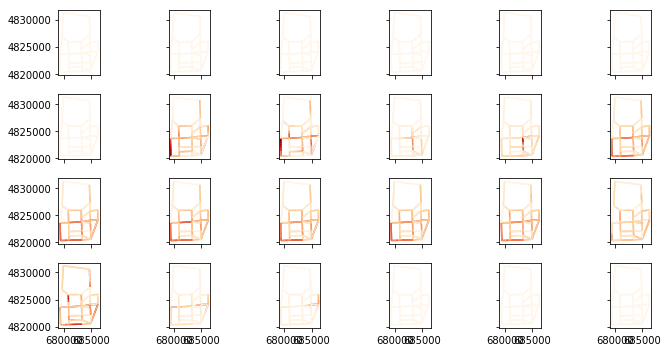

In [21]:
n_rows = 4
n_cols = 6
f, axes = plt.subplots(n_rows,n_cols, sharex=True, sharey=True, frameon=False)
for i in range(24):
    start = i
    end = i + 1
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    plot_volumes(network_frame, table, start, end, ax)

plt.tight_layout()